In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prediction.mcc import cca_mcc

# Model Selection

In [2]:
def agg_metrics_all(exp, seeds, models, data_dir, model_version):
    # found_seeds = []
    # val_scores = {model: [] for model in models}
    errs = []
    for seed in seeds:
        try:
            models_dir = f"{data_dir}-{seed}/"
            baseline_file = os.path.join(models_dir, exp, "non_invariant", model_version, "output/metrics.ood.csv")
            invariant_file = os.path.join(models_dir, exp, "invariant_nsamples_2_1.0", model_version, "output/metrics.val.csv")
            baseline_val_roc_auc = pd.read_csv(baseline_file).roc_auc.mean()
            invariant_val_roc_auc = pd.read_csv(invariant_file).roc_auc.mean()
            err = baseline_val_roc_auc - invariant_val_roc_auc
            errs.append((err, seed))
        except FileNotFoundError:
            continue
    if len(errs) == 0:
        for seed in seeds:
            try:
                models_dir = f"{data_dir}-{seed}/"
                invariant_file = os.path.join(models_dir, exp, "invariant_nsamples_2_1.0", model_version, "output/metrics.val.csv")
                invariant_val_roc_auc = pd.read_csv(invariant_file).roc_auc.mean()
                errs.append((invariant_val_roc_auc, seed))
            except FileNotFoundError:
                continue        
    return [b for a, b in sorted(errs, key=lambda x: x[0], reverse=True)[:5]]

def agg_metrics_all2(exp, seeds, model, data_dir, model_version):
    # found_seeds = []
    # val_scores = {model: [] for model in models}
    errs = []
    for seed in seeds:
        try:
            models_dir = f"{data_dir}-{seed}/"
            invariant_file = os.path.join(models_dir, exp, model, model_version, "output/metrics.val.csv")
            invariant_val_roc_auc = pd.read_csv(invariant_file).roc_auc.mean()
            errs.append((invariant_val_roc_auc, seed))
        except FileNotFoundError:
            continue        
    return [b for a, b in sorted(errs, key=lambda x: x[0], reverse=True)[:5]]
        
    #     for model in models:
    #         model_dir = os.path.join(models_dir, exp, model, model_version, "output")
    #         val_metrics_file = os.path.join(model_dir, "metrics.ood.csv")
    #         # val_metrics_file = os.path.join(model_dir, "metrics.ood.csv")
    #         try:
    #             val_roc_auc = pd.read_csv(val_metrics_file).roc_auc.mean()
    #         except FileNotFoundError:
    #             continue
    #         val_scores[model].append(val_roc_auc)
    # try:
    #     errs = np.array(val_scores[list(val_scores.keys())[0]]) - np.array(val_scores[list(val_scores.keys())[1]])
    #     return [a for a, b in sorted(zip(seeds, list(errs)), key=lambda x: x[1])][:5]
    # except ValueError:
    #     errs = np.array(val_scores[list(val_scores.keys())[1]])
    #     return [a for a, b in sorted(zip(seeds, list(errs)), key=lambda x: x[1], reverse=True)][:5]
    # errs = np.array(val_scores[list(val_scores.keys())[1]])
    # return [a for a, b in sorted(zip(seeds, list(errs)), key=lambda x: x[1], reverse=True)][:3]

# Test Metrics

In [3]:
def agg_metrics(exp, seeds, models, data_dir, model_version):  #, mcc_n):
    ood_scores = {model: [] for model in models}
    test_scores = {model: [] for model in models}
    # all_embeddings = {model: [] for model in models}
    for seed in seeds:
        # print(seed)
        models_dir = f"{data_dir}-{seed}/"
        for model in models:
            model_dir = os.path.join(models_dir, exp, model, model_version, "output")
            ood_metrics_file = os.path.join(model_dir, "metrics.ood.csv")
            test_metrics_file = os.path.join(model_dir, "metrics.test.csv")
            # embeddings_file = os.path.join(model_dir, "embeddings.test.csv")
            try:
                ood_roc_auc = pd.read_csv(ood_metrics_file).roc_auc.mean()
                test_roc_auc = pd.read_csv(test_metrics_file).roc_auc.mean()
                # embeddings = pd.read_csv(embeddings_file).drop('target', axis=1).drop('Protected', axis=1).values
            except FileNotFoundError:
                continue
            ood_scores[model].append(ood_roc_auc)
            test_scores[model].append(test_roc_auc)
            # all_embeddings[model].append(embeddings)
    ood_scores = {
        model: f"{round(np.array(scores).mean() * 100, 2)} ± {round(np.array(scores).std() * 100, 2)}"
        for model, scores in ood_scores.items()
    }
    test_scores = {
        model: f"{round(np.array(scores).mean() * 100, 2)} ± {round(np.array(scores).std() * 100, 2)}"
        for model, scores in test_scores.items()
    }
    # mccs = {
    #     model: [cca_mcc(embeds[i - 1][:mcc_n], embeds[i][:mcc_n]) for i in range(1, len(embeds))]
    #     for model, embeds in all_embeddings.items()
    # }
    # mccs = {
    #     model: f"{round(np.array(scores).mean(), 4)} ± {round(np.array(scores).std(), 4)}"
    #     for model, scores in mccs.items()
    # }
    return test_scores, ood_scores  #, mccs

## Pleural Effusion - Race Invariance

In [4]:
seeds = list(range(44, 54))


def select_seeds(data_dir, seeds, reverse):
    errs = []
    for seed in seeds:
        try:
            _data_dir = data_dir(seed)
            file = f"{_data_dir}/lightning_logs/version_0/output/metrics.val.csv"
            auroc = pd.read_csv(file).roc_auc.mean()
            errs.append((auroc, seed))
        except FileNotFoundError:
            continue
    return [b for a, b in sorted(errs, key=lambda x: x[0], reverse=reverse)[:5]]

def agg_metrics(seeds, data_dir, split):
    scores = []
    for seed in seeds:
        _data_dir = data_dir(seed)
        file = f"{_data_dir}/lightning_logs/version_0/output/metrics.{split}.csv"
        auroc = pd.read_csv(file).roc_auc.mean()
        scores.append(auroc)
    return np.mean(scores), np.std(scores)


baseline_name = "non_invariant"
inv_name = "invariant_nsamples_2_1.0"
logdir = "/vol/biomedic3/rrr2417/chexploration_with_crl/logs/"
for disease in ["Pleural_Effusion", "Cardiomegaly"]:
    for model in ["ResNet18", "EfficientNetB0", "DenseNet"]:
        for inv, exp in [
            ("sex", baseline_name),
            ("view", inv_name),
            ("race", inv_name),
            ("sex", inv_name),
        ]:
            row_str = r"\textsc{" + model + r"}" if exp == "non_invariant" else r"$\sim$ \textsc{" + f"{inv.capitalize()} Inv." + r"}"
            row_str += " & "
            for i, (ds, split) in enumerate([
                ("chexpert_mimic", "test"),
                ("mimic_chexpert", "test"),
                ("chexpert_mimic", "ood"),
                ("mimic_chexpert", "ood"),
            ]):
                data_dir = lambda seed: f"{logdir}/cxr_{inv}_{disease}_224/{model}-{seed}/{ds}/{exp}/"
                chosen_seeds = select_seeds(data_dir, seeds, exp != baseline_name)
                mean, std = agg_metrics(chosen_seeds, data_dir, split)
                row_str += f"{round(mean * 100, 2)} ± {round(std * 100, 2)} & "
            print(row_str[:-2] + r"\\")

\textsc{ResNet18} & 93.04 ± 0.88 & 94.31 ± 0.11 & 90.87 ± 1.51 & 94.08 ± 0.32 \\
$\sim$ \textsc{View Inv.} & 93.78 ± 0.21 & 93.87 ± 0.32 & 92.6 ± 0.52 & 93.78 ± 0.38 \\
$\sim$ \textsc{Race Inv.} & 94.23 ± 0.09 & 94.04 ± 0.08 & 92.78 ± 0.1 & 93.97 ± 0.23 \\


KeyboardInterrupt: 

In [53]:
from sklearn.decomposition import PCA

for ds, ds_name in [("chexpert_mimic", "CheXpert"), ("mimic_chexpert", "MIMIC")]:
    print(r"& \multicolumn{4}{c}{\textbf{" + ds_name + r"}} \\")
    print(r"\hline")
    for disease in ["Pleural_Effusion", "Cardiomegaly"]:
        print(r"& \multicolumn{4}{c}{\texttt{no findings} vs \texttt{" + disease.lower().replace("_", " ") + r"}} \\")
        print(r"\hline")
        for model in ["ResNet18", "EfficientNetB0", "DenseNet"]:
            row_str = r"\textsc{" + model + r"}" # if exp == "non_invariant" else r"$\sim$ \textsc{" + f"{inv.capitalize()} Inv." + r"}"
            row_str += " & "
            for inv, exp in (("sex", baseline_name), ("view", inv_name), ("race", inv_name), ("sex", inv_name)):
            # for ds in ["chexpert_mimic", "mimic_chexpert"]:
                data_dir = lambda seed: f"{logdir}/cxr_{inv}_{disease}_224/{model}-{seed}/{ds}/{exp}/"
                chosen_seeds = select_seeds(data_dir, seeds, exp != baseline_name)
                # scores = {"std0": [], "std1": [], "delta": []}
                # scores = {"std": [], "delta": []}
                scores = {"delta": []}
                for seed in chosen_seeds:
                    emb_file = data_dir(seed) + "/lightning_logs/version_0/output/embeddings.test.csv"
                    df = pd.read_csv(emb_file)
                    target = df.target
                    embs = df.drop('target', axis=1).drop('Protected', axis=1).values
                    embs_pca = PCA(n_components=1, whiten=False).fit_transform(embs)
                    spread = np.linalg.norm(embs_pca.max(axis=0) - embs_pca.min(axis=0))
                    d = np.linalg.norm(embs_pca[target == 0].mean(axis=0) - embs_pca[target == 1].mean(axis=0))
                    # std = (embs_pca[target == 0].std(axis=0).mean() + embs_pca[target == 1].std(axis=0).mean()) / 2
                    # scores["std0"].append(embs_pca[target == 0].std(axis=0).mean() / d)
                    # scores["std1"].append(embs_pca[target == 1].std(axis=0).mean() / d)
                    scores["delta"].append(d / spread)
                    # scores["std"].append(std / spread)
                avg_scores = {k: (round(np.mean(v), 3), round(np.std(v), 3)) for k, v in scores.items()}
                row_str += f"{avg_scores["delta"][0]} ± {avg_scores["delta"][1]} & "
                # row_str += f"{avg_scores["std"][0]} ± {avg_scores["std"][1]} & "
                # row_str += f"{avg_scores["std0"][0]} ± {avg_scores["std0"][1]} & "
                # row_str += f"{avg_scores["std1"][0]} ± {avg_scores["std1"][1]} & "
            print(row_str[:-2] + r"\\")
    print(r"\hline")

& \multicolumn{4}{c}{\textbf{CheXpert}} \\
\hline
& \multicolumn{4}{c}{\texttt{no findings} vs \texttt{pleural effusion}} \\
\hline
\textsc{ResNet18} & 0.245 ± 0.039 & 0.35 ± 0.011 & 0.406 ± 0.013 & 0.404 ± 0.017 \\
\textsc{EfficientNetB0} & 0.379 ± 0.047 & 0.353 ± 0.037 & 0.392 ± 0.017 & 0.414 ± 0.035 \\
\textsc{DenseNet} & 0.244 ± 0.017 & 0.33 ± 0.019 & 0.339 ± 0.028 & 0.365 ± 0.025 \\
& \multicolumn{4}{c}{\texttt{no findings} vs \texttt{cardiomegaly}} \\
\hline
\textsc{ResNet18} & 0.086 ± 0.017 & 0.271 ± 0.024 & 0.314 ± 0.013 & 0.295 ± 0.019 \\
\textsc{EfficientNetB0} & 0.24 ± 0.029 & 0.293 ± 0.026 & 0.334 ± 0.011 & 0.298 ± 0.021 \\
\textsc{DenseNet} & 0.034 ± 0.011 & 0.248 ± 0.019 & 0.267 ± 0.012 & 0.277 ± 0.012 \\
\hline
& \multicolumn{4}{c}{\textbf{MIMIC}} \\
\hline
& \multicolumn{4}{c}{\texttt{no findings} vs \texttt{pleural effusion}} \\
\hline
\textsc{ResNet18} & 0.281 ± 0.032 & 0.331 ± 0.012 & 0.381 ± 0.018 & 0.377 ± 0.022 \\
\textsc{EfficientNetB0} & 0.334 ± 0.011 & 0.34 ± 0

In [8]:
from prediction.datasets.cxr import CXRDataModule
from prediction.race_invariance import datafiles

basedir = "/vol/biomedic3/rrr2417/chexploration_with_crl/"

counts = {"No Findings": [], "Pleural Effusion": [], "Cardiomegaly": []}
for dataset in ["chexpert", "mimic"]:
    for disease in ["Pleural Effusion", "Cardiomegaly"]:
        print(">", dataset, disease)
        csv_train_img, csv_val_img, csv_test_img, img_data_dir = datafiles(dataset)
        data_chexpert = CXRDataModule(
            csv_train_img=os.path.join(basedir, csv_train_img),
            csv_val_img=os.path.join(basedir, csv_val_img),
            csv_test_img=os.path.join(basedir, csv_test_img),
            img_data_dir=img_data_dir,
            batch_size=32,
            pseudo_rgb=True,
            num_workers=3,
            image_size=(224, 224),
            invariant_sampling=False,
            disease_name=disease,
        )
        train_counts = data_chexpert.train_set.data.label.value_counts().to_dict()
        val_counts = data_chexpert.val_set.data.label.value_counts().to_dict()
        test_counts = data_chexpert.test_set.data.label.value_counts().to_dict()
        counts[disease].extend([train_counts[1], val_counts[1], test_counts[1]])
    counts["No Findings"].extend([train_counts[0], val_counts[0], test_counts[0]])

for row in ["No Findings", "Pleural Effusion", "Cardiomegaly"]:
    row_str = r"\textsc{" + row + "} & "
    for count in counts[row]:
        row_str += f"{count} & "
    print(row_str[:-3] + r" \\")

> chexpert Pleural Effusion


Loading Data: 100%|████████████████████████████████████████████████████████████████████████| 18826/18826 [00:00<00:00, 41334.92it/s]


#train:  37529
#val:    6135
#test:   18826
> chexpert Cardiomegaly


Loading Data: 100%|██████████████████████████████████████████████████████████████████████████| 8205/8205 [00:00<00:00, 34319.20it/s]


#train:  15867
#val:    2634
#test:   8205
> mimic Pleural Effusion


Loading Data: 100%|████████████████████████████████████████████████████████████████████████| 30535/30535 [00:00<00:00, 38294.82it/s]


#train:  62336
#val:    9968
#test:   30535
> mimic Cardiomegaly


Loading Data: 100%|████████████████████████████████████████████████████████████████████████| 28176/28176 [00:00<00:00, 41948.71it/s]

#train:  56687
#val:    9053
#test:   28176
\textsc{No Findings} & 6514 & 1086 & 3316 & 34530 & 5393 & 16692 \\
\textsc{Pleural Effusion} & 31015 & 5049 & 15510 & 27806 & 4575 & 13843 \\
\textsc{Cardiomegaly} & 9353 & 1548 & 4889 & 22157 & 3660 & 11484 \\


DenseNet


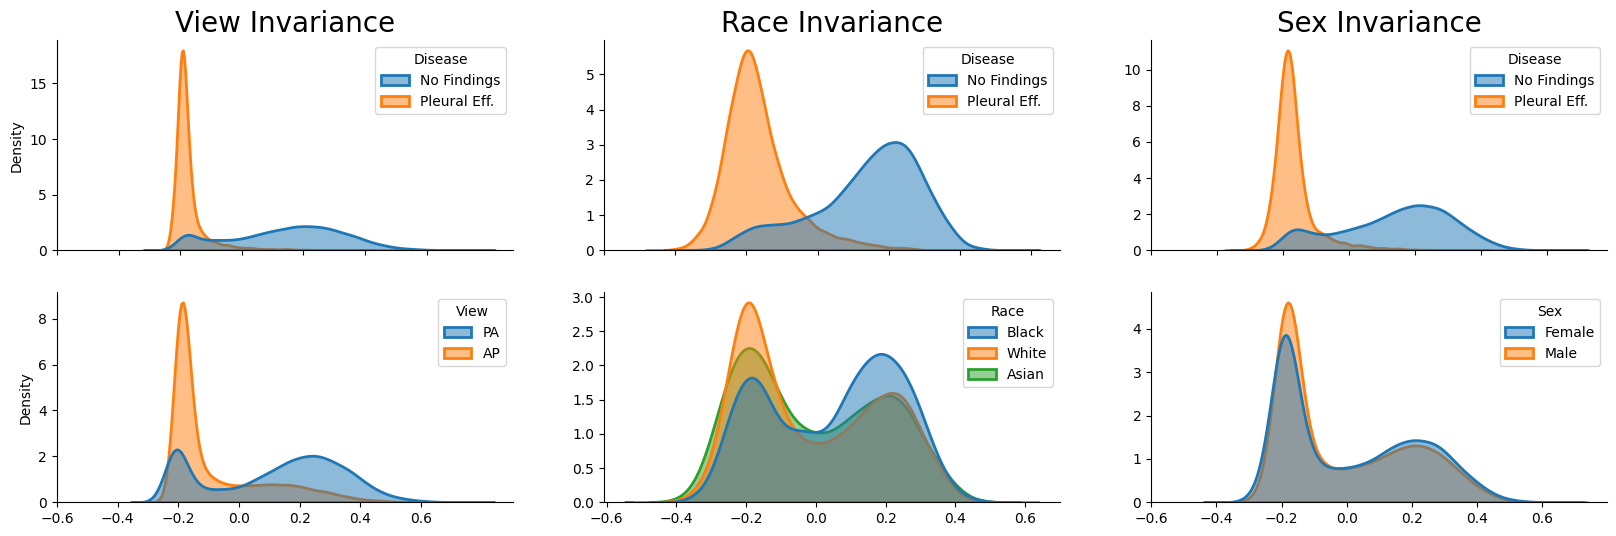

In [75]:
import matplotlib as mpl
from sklearn.decomposition import PCA

seeds = list(range(44, 54))

def select_seeds(data_dir, seeds, reverse):
    errs = []
    for seed in seeds:
        try:
            _data_dir = data_dir(seed)
            file = f"{_data_dir}/lightning_logs/version_0/output/metrics.val.csv"
            auroc = pd.read_csv(file).roc_auc.mean()
            errs.append((auroc, seed))
        except FileNotFoundError:
            continue
    return [b for a, b in sorted(errs, key=lambda x: x[0], reverse=reverse)[:5]]

clusters = {
    "view": {0: "AP", 1: "PA"},
    "sex": {0: "Male", 1: "Female"},
    "race": {0: "White", 1: "Asian", 2: "Black"},
}

# mpl.rcParams['ytick.labelsize'] = 18  # Size for y-axis tick labels
# mpl.rcParams['axes.labelsize'] = 18   # Size for axis labels

baseline_name = "non_invariant"
inv_name = "invariant_nsamples_2_1.0"
logdir = "/vol/biomedic3/rrr2417/chexploration_with_crl/logs/"
for model in ["DenseNet"]: #, "EfficientNetB0", "DenseNet"]:
    print(model)
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 6))
    for i, (inv, exp) in enumerate([
        ("view", inv_name),
        ("race", inv_name),
        ("sex", inv_name),
    ]):
        data_dir = lambda seed: f"{logdir}/cxr_{inv}_Pleural_Effusion_224/{model}-{seed}/mimic_chexpert/{exp}/"
        # chosen_seed = select_seeds(data_dir, seeds, exp != baseline_name)[0]
        # print(chosen_seed)
        emb_file = f"{data_dir(48)}/lightning_logs/version_0/output/embeddings.test.csv"
        df = pd.read_csv(emb_file)
        df = df.rename(columns={"target": "Disease", "Protected": inv.capitalize()})
        df["Disease"] = df['Disease'].map({0: "No Findings", 1: "Pleural Eff."})
        df[inv.capitalize()] = df[inv.capitalize()].map(clusters[inv])
        embeds = df.drop('Disease', axis=1).drop(inv.capitalize(), axis=1).values
        embs_pca = PCA(n_components=1, whiten=False).fit_transform(embeds)
        spread = np.linalg.norm(embs_pca.max(axis=0) - embs_pca.min(axis=0))
        df["proj"] = embs_pca / spread
        axes[0, i].set_title(f"{inv.capitalize()} Invariance", fontsize=20)
        g = sns.kdeplot(
            data=df, x="proj", hue="Disease",
            fill=True, common_norm=False, palette="tab10",
            alpha=.5, linewidth=2, ax=axes[0, i],
            legend="auto",
        )
        g.set(xlabel=False, xticks=[-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6]) #, yticks=[for x in range(0, 10)])
        g.tick_params(axis='x', labelbottom=False)
        g.set_xlabel("")
        g.spines['top'].set_visible(False)
        g.spines['right'].set_visible(False)
        if i > 0:
            g.set(ylabel=None)
        g = sns.kdeplot(
            data=df, x="proj", hue=inv.capitalize(),
            fill=True, common_norm=False, palette="tab10",
            alpha=.5, linewidth=2, ax=axes[1, i],
            legend="auto",
        )
        g.set(xlabel=False, xticks=[-0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6]) #, xticks=list(range(-5, 6))) #, yticks=[0.0, 0.1, 0.2, 0.3, 0.4])
        g.set_xlabel("")
        g.spines['top'].set_visible(False)
        g.spines['right'].set_visible(False)
        if i > 0:
            g.set(ylabel=None)
    plt.savefig("invariance_clusters_1d.pdf", bbox_inches="tight")
    plt.show()

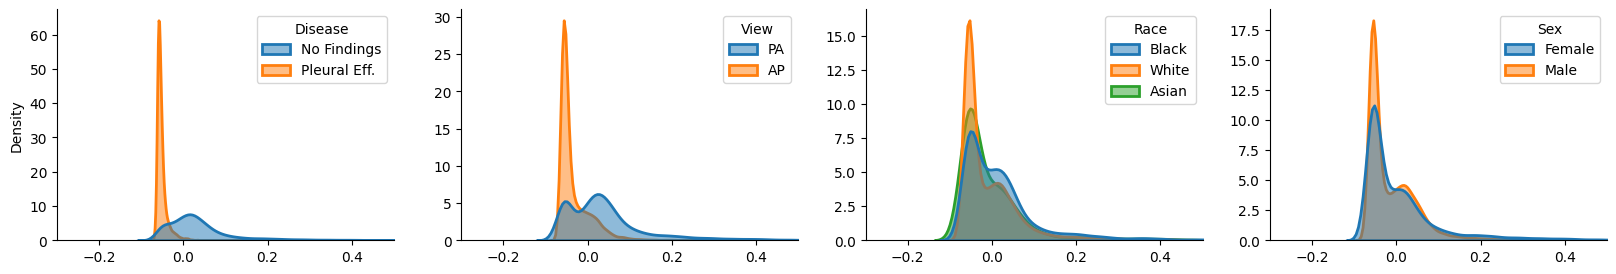

In [79]:
import matplotlib as mpl
from sklearn.decomposition import PCA

seeds = list(range(44, 54))

def select_seeds(data_dir, seeds, reverse):
    errs = []
    for seed in seeds:
        try:
            _data_dir = data_dir(seed)
            file = f"{_data_dir}/lightning_logs/version_0/output/metrics.val.csv"
            auroc = pd.read_csv(file).roc_auc.mean()
            errs.append((auroc, seed))
        except FileNotFoundError:
            continue
    return [b for a, b in sorted(errs, key=lambda x: x[0], reverse=reverse)[:5]]

clusters = {
    "view": {0: "AP", 1: "PA"},
    "sex": {0: "Male", 1: "Female"},
    "race": {0: "White", 1: "Asian", 2: "Black"},
}


data_dir1 = lambda inv: f"{logdir}/cxr_{inv}_Pleural_Effusion_224/DenseNet-48/mimic_chexpert/non_invariant/lightning_logs/version_0/output/embeddings.test.csv"
data_dir2 = lambda inv: f"{logdir}/cxr_{inv}_Pleural_Effusion_224/DenseNet-44/mimic_chexpert/invariant_nsamples_2_1.0/lightning_logs/version_0/output/embeddings.test.csv"
df = pd.read_csv(data_dir1("sex"))
view_attr = pd.read_csv(data_dir2("view"))["Protected"].map({0: "AP", 1: "PA"})
race_attr = pd.read_csv(data_dir2("race"))["Protected"].map({0: "White", 1: "Asian", 2: "Black"})
sex_attr = pd.read_csv(data_dir2("sex"))["Protected"].map({0: "Male", 1: "Female"})
df["View"] = view_attr
df["Race"] = race_attr
df["Sex"] = sex_attr
df = df.rename(columns={"target": "Disease"})
df["Disease"] = df["Disease"].map({0: "No Findings", 1: "Pleural Eff."})

embeds = df.drop('Disease', axis=1) \
    .drop('View', axis=1) \
    .drop('Race', axis=1) \
    .drop('Sex', axis=1) \
    .values
embs_pca = PCA(n_components=1, whiten=False).fit_transform(embeds)
spread = np.linalg.norm(embs_pca.max(axis=0) - embs_pca.min(axis=0))
df["proj"] = embs_pca / spread

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 3))

for i, inv in enumerate(["Disease", "View", "Race", "Sex"]):
    # axes[i].set_title(f"{inv} Invariance", fontsize=15)
    g = sns.kdeplot(
        data=df, x="proj", hue=inv,
        fill=True, common_norm=False, palette="tab10",
        alpha=.5, linewidth=2, ax=axes[i],
        legend="auto",
    )
    g.set(xticks=[-0.2, 0, 0.2, 0.4], xlim=(-0.3, 0.5)) #, 5, 7.5, 10]) #, yticks=[0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35])
    g.set_xlabel("")
    g.spines['top'].set_visible(False)
    g.spines['right'].set_visible(False)
    if i > 0:
        g.set(ylabel=None)
plt.savefig("non_invariance_clusters_1d.pdf", bbox_inches="tight")
plt.show()
    

# baseline_name = "non_invariant"
# inv_name = "invariant_nsamples_2_1.0"
# logdir = "/vol/biomedic3/rrr2417/chexploration_with_crl/logs/"
# for model in ["EfficientNetB0"]: #, "EfficientNetB0", "DenseNet"]:
#     print(model)
#     fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
#     for i, (inv, exp) in enumerate([
#         ("sex", baseline_name),
#         ("view", baseline_name),
#         ("race", baseline_name),
#         ("sex", baseline_name),
#     ]):
#         data_dir = lambda seed: f"{logdir}/cxr_sex_Pleural_Effusion_224/{model}-{seed}/mimic_chexpert/{exp}/lightning_logs/version_0/output/embeddings.test.csv""
#         emb_file = f"{data_dir(48)}/lightning_logs/version_0/output/embeddings.test.csv"
#         df = pd.read_csv(emb_file)
#         df = df.rename(columns={"target": "Disease", "Protected": inv.capitalize()})
#         df["Disease"] = df['Disease'].map({0: "No Findings", 1: "Pleural Eff."})
#         df[inv.capitalize()] = df[inv.capitalize()].map(clusters[inv])
#         embeds = df.drop('Disease', axis=1).drop(inv.capitalize(), axis=1).values
#         df["proj"] = PCA(n_components=1, whiten=False).fit_transform(embeds)
#         axes[i].set_title(f"{inv.capitalize()} Invariance", fontsize=20)
#         g = sns.kdeplot(
#             data=df, x="proj", hue="Disease",
#             fill=True, common_norm=True, palette="crest",
#             alpha=.5, linewidth=0, ax=axes[i],
#             legend="auto",
#         )
#         g.set(xlabel=False, xticks=list(range(-5, 6)), yticks=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
#         g.tick_params(axis='x', labelbottom=False)
#         g.set_xlabel("")
#         g.spines['top'].set_visible(False)
#         g.spines['right'].set_visible(False)
#         if i > 0:
#             g.set(ylabel=None)
#         # g = sns.kdeplot(
#         #     data=df, x="proj", hue=inv.capitalize(),
#         #     fill=True, common_norm=True, palette="crest",
#         #     alpha=.5, linewidth=0, ax=axes[1, i],
#         #     legend="auto",
#         # )
#         # g.set(xlabel=False, xticks=list(range(-5, 6)), yticks=[0.0, 0.1, 0.2, 0.3, 0.4])
#         # g.set_xlabel("")
#         # g.spines['top'].set_visible(False)
#         # g.spines['right'].set_visible(False)
#         # if i > 0:
#         #     g.set(ylabel=None)
#     plt.savefig("non_invariance_clusters_1d.pdf", bbox_inches="tight")
#     plt.show()

In [32]:
!ls /vol/biomedic3/rrr2417/chexploration_with_crl/logs//cxr_view_Pleural_Effusion_224/ResNet18-48/mimic_chexpert/non_invariant/lightning_logs/version_0/output/

ls: cannot access '/vol/biomedic3/rrr2417/chexploration_with_crl/logs//cxr_view_Pleural_Effusion_224/ResNet18-48/mimic_chexpert/non_invariant/lightning_logs/version_0/output/': No such file or directory


In [ ]:
logdir = "/vol/biomedic3/rrr2417/chexploration_with_crl/logs/"
for disease in ["Pleural_Effusion", "Cardiomegaly"]:
    for model in ["ResNet18", "EfficientNetB0"]:
        for inv, exp in [
            ("sex", "non_invariant"),
            ("view", "invariant_nsamples_2_1.0"),
            ("race", "invariant_nsamples_2_1.0"),
            ("sex", "invariant_nsamples_2_1.0"),
        ]:
            row_str = r"\textsc{" + model + r"} & " if exp == "non_invariant" else r"$\sim$ \textsc{" + f"{inv.capitalize()} Inv." + r"}"
            row_str += " & "
            for i, (ds, split) in enumerate([
                ("chexpert_mimic", "test"),
                ("mimic_chexpert", "test"),
                ("chexpert_mimic", "ood"),
                ("mimic_chexpert", "ood"),
            ]):
                data_dir = lambda seed: f"{logdir}/cxr_{inv}_{disease}_224/{model}-{seed}/{ds}/{exp}/"
                chosen_seeds = select_seeds(data_dir, seeds, exp != "non_invariant")
                mean, std = agg_metrics(chosen_seeds, data_dir, split)
                row_str += f"{round(mean * 100, 2)} ± {round(std * 100, 2)}"
                if i == 3:
                    row_str += r" \\"
                else:
                    row_str += " & "
            print(row_str)

In [55]:

                
            
        print(inv, disease)
        cxr_pe_dir_resnet_race = logdir + f"cxr_{inv}_{disease}_224/ResNet18"
        cxr_cm_pe_models_race_resnet = agg_metrics_all(
            "chexpert_mimic",
            seeds,
            model_names,
            cxr_pe_dir_resnet_race,
            version,
        )
        cxr_mc_pe_models_race_resnet = agg_metrics_all(
            "mimic_chexpert",
            seeds,
            model_names,
            cxr_pe_dir_resnet_race,
            version,
        )
        print('res', cxr_cm_pe_models_race_resnet, cxr_mc_pe_models_race_resnet)
        
        cxr_pe_dir_effnet_race = logdir + f"cxr_{inv}_{disease}_224/EfficientNetB0"
        cxr_cm_pe_models_race_effnet = agg_metrics_all(
            "chexpert_mimic",
            seeds,
            model_names,
            cxr_pe_dir_effnet_race,
            version,
        )
        cxr_mc_pe_models_race_effnet = agg_metrics_all(
            "mimic_chexpert",
            seeds,
            model_names,
            cxr_pe_dir_effnet_race,
            version,
        )
        print('eff', cxr_cm_pe_models_race_effnet, cxr_mc_pe_models_race_effnet)
        
        # print("chexpert_mimic")
        test_scores_cm_resnet_race, ood_scores_cm_resnet_race = agg_metrics(
            "chexpert_mimic",
            cxr_cm_pe_models_race_resnet,
            model_names,
            cxr_pe_dir_resnet_race,
            version,
        )
        # print()
        # print("mimic_chexpert")
        test_scores_mc_resnet_race, ood_scores_mc_resnet_race = agg_metrics(
            "mimic_chexpert",
            cxr_mc_pe_models_race_resnet,
            model_names,
            cxr_pe_dir_resnet_race,
            version,
        )
        # print()
        
        # print("chexpert_mimic")
        test_scores_cm_effnet_race, ood_scores_cm_effnet_race = agg_metrics(
            "chexpert_mimic",
            cxr_cm_pe_models_race_effnet,
            model_names,
            cxr_pe_dir_effnet_race,
            version,
        )
        # print()
        # print("mimic_chexpert")
        test_scores_mc_effnet_race, ood_scores_mc_effnet_race = agg_metrics(
            "mimic_chexpert",
            cxr_mc_pe_models_race_effnet,
            model_names,
            cxr_pe_dir_effnet_race,
            version,
        )
        # print()
        
        for model, key in [
            (r"\textsc{ResNet18}", "non_invariant"),
            (r"\textsc{$\sim$ " + inv.capitalize() + r" Inv.}", "invariant_nsamples_2_1.0"),
        ]:
            print(model, end=r" & ")
            print(test_scores_cm_resnet_race[key], end=r" & ")
            print(test_scores_mc_resnet_race[key], end=r" & ")
            print(ood_scores_cm_resnet_race[key], end=r" & ")
            print(ood_scores_mc_resnet_race[key], end=r" \\ ")
            print()
        
        for model, key in [
            (r"\textsc{EfficientNetB0}", "non_invariant"),
            (r"\textsc{$\sim$ " + inv.capitalize() + r" Inv.}", "invariant_nsamples_2_1.0"),
        ]:
            print(model, end=r" & ")
            print(test_scores_cm_effnet_race[key], end=r" & ")
            print(test_scores_mc_effnet_race[key], end=r" & ")
            print(ood_scores_cm_effnet_race[key], end=r" & ")
            print(ood_scores_mc_effnet_race[key], end=r" \\ ")
            print()

        print()

view Pleural_Effusion
res [46, 47, 48, 44, 45] [49, 48, 47, 46, 45]
eff [46, 44, 45, 48, 49] [44, 47, 46, 48, 49]
\textsc{ResNet18} & nan ± nan & nan ± nan & nan ± nan & nan ± nan \\ 
\textsc{$\sim$ View Inv.} & 93.78 ± 0.21 & 93.87 ± 0.32 & 92.6 ± 0.52 & 93.78 ± 0.38 \\ 
\textsc{EfficientNetB0} & nan ± nan & nan ± nan & nan ± nan & nan ± nan \\ 
\textsc{$\sim$ View Inv.} & 93.46 ± 0.47 & 94.2 ± 0.12 & 91.95 ± 1.19 & 93.88 ± 0.28 \\ 

race Pleural_Effusion


/tmp/ipykernel_3819800/66726526.py:23: RuntimeWarning: Mean of empty slice.
  model: f"{round(np.array(scores).mean() * 100, 2)} ± {round(np.array(scores).std() * 100, 2)}"
/vol/biomedic3/rrr2417/chexploration_with_crl/.venv/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/vol/biomedic3/rrr2417/chexploration_with_crl/.venv/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/vol/biomedic3/rrr2417/chexploration_with_crl/.venv/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/vol/biomedic3/rrr2417/chexploration_with_crl/.venv/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.ty

res [49, 53, 52, 45, 47] [48, 51, 45, 44, 50]
eff [46, 49, 44, 50, 48] [51, 47, 52, 49, 53]
\textsc{ResNet18} & 93.42 ± 0.39 & 94.41 ± 0.12 & 91.58 ± 0.7 & 94.41 ± 0.09 \\ 
\textsc{$\sim$ Race Inv.} & 94.12 ± 0.18 & 93.81 ± 0.19 & 92.92 ± 0.18 & 93.89 ± 0.32 \\ 
\textsc{EfficientNetB0} & 94.16 ± 0.39 & 94.58 ± 0.11 & 92.81 ± 0.3 & 94.6 ± 0.16 \\ 
\textsc{$\sim$ Race Inv.} & 94.19 ± 0.4 & 93.95 ± 0.31 & 92.84 ± 0.96 & 93.58 ± 0.76 \\ 

sex Pleural_Effusion
res [47, 46, 49, 45, 48] [44, 46, 47, 48, 45]
eff [46, 48, 45, 44, 47] [45, 44, 46, 47, 48]
\textsc{ResNet18} & 93.45 ± 0.7 & 94.38 ± 0.16 & 91.53 ± 1.35 & 94.09 ± 0.32 \\ 
\textsc{$\sim$ Sex Inv.} & 94.46 ± 0.13 & 94.27 ± 0.15 & 93.22 ± 0.27 & 94.32 ± 0.12 \\ 
\textsc{EfficientNetB0} & 93.19 ± 0.77 & 94.62 ± 0.1 & 91.95 ± 0.87 & 94.51 ± 0.15 \\ 
\textsc{$\sim$ Sex Inv.} & 94.56 ± 0.19 & 94.46 ± 0.04 & 93.43 ± 0.24 & 94.41 ± 0.18 \\ 

view Cardiomegaly
res [45, 44, 46, 48, 47] [47, 44, 46, 45, 48]
eff [48, 49, 45, 47, 46] [49, 47, 44,

/tmp/ipykernel_3819800/66726526.py:23: RuntimeWarning: Mean of empty slice.
  model: f"{round(np.array(scores).mean() * 100, 2)} ± {round(np.array(scores).std() * 100, 2)}"
/vol/biomedic3/rrr2417/chexploration_with_crl/.venv/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/vol/biomedic3/rrr2417/chexploration_with_crl/.venv/lib/python3.12/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/vol/biomedic3/rrr2417/chexploration_with_crl/.venv/lib/python3.12/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/vol/biomedic3/rrr2417/chexploration_with_crl/.venv/lib/python3.12/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.ty

res [52, 53, 46, 45, 50] [51, 50, 48, 53, 46]
eff [49, 51, 47, 52, 50] [51, 53, 50, 52, 48]
\textsc{ResNet18} & 90.59 ± 0.88 & 88.43 ± 1.53 & 89.82 ± 1.54 & 86.83 ± 1.87 \\ 
\textsc{$\sim$ Race Inv.} & 89.56 ± 1.29 & 89.76 ± 1.61 & 89.19 ± 1.55 & 87.16 ± 2.44 \\ 
\textsc{EfficientNetB0} & 90.29 ± 1.28 & 89.4 ± 0.67 & 88.7 ± 1.85 & 87.5 ± 0.72 \\ 
\textsc{$\sim$ Race Inv.} & 91.03 ± 0.44 & 91.92 ± 0.22 & 90.37 ± 0.77 & 89.94 ± 0.54 \\ 

sex Cardiomegaly
res [45, 49, 47, 48, 44] [45, 47, 49, 48, 44]
eff [46, 49, 47, 44, 45] [47, 44, 48, 49, 46]
\textsc{ResNet18} & 89.88 ± 1.22 & 88.05 ± 0.89 & 88.81 ± 1.87 & 86.92 ± 1.31 \\ 
\textsc{$\sim$ Sex Inv.} & 90.77 ± 0.76 & 92.33 ± 0.16 & 90.64 ± 0.6 & 91.17 ± 0.1 \\ 
\textsc{EfficientNetB0} & 89.63 ± 1.45 & 89.3 ± 1.01 & 88.99 ± 2.11 & 86.99 ± 1.51 \\ 
\textsc{$\sim$ Sex Inv.} & 90.14 ± 0.84 & 92.41 ± 0.12 & 89.35 ± 1.09 & 91.18 ± 0.21 \\ 



## MCC

In [112]:
def mcc_score(exp, seeds, model, data_dir, model_version, mcc_n):
    embeds = []
    for seed in seeds:
        models_dir = f"{data_dir}-{seed}/"
        model_dir = os.path.join(models_dir, exp, model, model_version, "output")
        embeddings_file = os.path.join(model_dir, "embeddings.test.csv")
        try:
            embed = pd.read_csv(embeddings_file).drop('target', axis=1).drop('Protected', axis=1).values
        except FileNotFoundError:
            continue
        embeds.append(embed)
    try:
        scores = [cca_mcc(embeds[i - 1][:mcc_n], embeds[i][:mcc_n]) for i in range(1, len(embeds))]
        mcc_score = f"{round(np.array(scores).mean(), 4)} ± {round(np.array(scores).std(), 4)}"
        return mcc_score
    except np.linalg.LinAlgError:
        return np.nan

In [114]:
for disease in ["Pleural_Effusion", "Cardiomegaly"]:
    print(disease.replace("_", " "))
    for dataset in ["chexpert_mimic", "mimic_chexpert"]:
        print(dataset.split("_")[0].capitalize())
        for model in ["ResNet18", "EfficientNetB0"]:
            for inv in ["view", "race", "sex"]:
                print(inv)
                model_dir = logdir + f"cxr_{inv}_{disease}_224/{model}"
                chosen_models = agg_metrics_all(
                    dataset,
                    list(range(43, 54)),
                    model_names,
                    model_dir,
                    version,
                )
                mcc = mcc_score(dataset, chosen_models, model_names[1], model_dir, version, 1000)                
                print(mcc)
    print()

Pleural Effusion
Chexpert
view


/vol/biomedic3/rrr2417/chexploration_with_crl/.venv/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/vol/biomedic3/rrr2417/chexploration_with_crl/.venv/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


nan
race


/vol/biomedic3/rrr2417/chexploration_with_crl/.venv/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/vol/biomedic3/rrr2417/chexploration_with_crl/.venv/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/vol/biomedic3/rrr2417/chexploration_with_crl/.venv/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


0.9986 ± 0.0001
sex


/vol/biomedic3/rrr2417/chexploration_with_crl/.venv/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/vol/biomedic3/rrr2417/chexploration_with_crl/.venv/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/vol/biomedic3/rrr2417/chexploration_with_crl/.venv/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


0.9986 ± 0.0001
view
1.0 ± 0.0
race
1.0 ± 0.0
sex
1.0 ± 0.0
Mimic
view


/vol/biomedic3/rrr2417/chexploration_with_crl/.venv/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/vol/biomedic3/rrr2417/chexploration_with_crl/.venv/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/vol/biomedic3/rrr2417/chexploration_with_crl/.venv/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/vol/biomedic3/rrr2417/chexploration_with_crl/.venv/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", 

0.9987 ± 0.0001
race


/vol/biomedic3/rrr2417/chexploration_with_crl/.venv/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/vol/biomedic3/rrr2417/chexploration_with_crl/.venv/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/vol/biomedic3/rrr2417/chexploration_with_crl/.venv/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


0.9987 ± 0.0
sex


/vol/biomedic3/rrr2417/chexploration_with_crl/.venv/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/vol/biomedic3/rrr2417/chexploration_with_crl/.venv/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/vol/biomedic3/rrr2417/chexploration_with_crl/.venv/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


0.9986 ± 0.0
view
1.0 ± 0.0
race
1.0 ± 0.0
sex
1.0 ± 0.0

Cardiomegaly
Chexpert
view


/vol/biomedic3/rrr2417/chexploration_with_crl/.venv/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/vol/biomedic3/rrr2417/chexploration_with_crl/.venv/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/vol/biomedic3/rrr2417/chexploration_with_crl/.venv/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


0.9986 ± 0.0
race


/vol/biomedic3/rrr2417/chexploration_with_crl/.venv/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/vol/biomedic3/rrr2417/chexploration_with_crl/.venv/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/vol/biomedic3/rrr2417/chexploration_with_crl/.venv/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


0.9986 ± 0.0
sex


/vol/biomedic3/rrr2417/chexploration_with_crl/.venv/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/vol/biomedic3/rrr2417/chexploration_with_crl/.venv/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/vol/biomedic3/rrr2417/chexploration_with_crl/.venv/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


0.9986 ± 0.0001
view
1.0 ± 0.0
race
1.0 ± 0.0
sex
1.0 ± 0.0
Mimic
view


/vol/biomedic3/rrr2417/chexploration_with_crl/.venv/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/vol/biomedic3/rrr2417/chexploration_with_crl/.venv/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/vol/biomedic3/rrr2417/chexploration_with_crl/.venv/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


0.9986 ± 0.0001
race


/vol/biomedic3/rrr2417/chexploration_with_crl/.venv/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/vol/biomedic3/rrr2417/chexploration_with_crl/.venv/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/vol/biomedic3/rrr2417/chexploration_with_crl/.venv/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/vol/biomedic3/rrr2417/chexploration_with_crl/.venv/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", 

0.9987 ± 0.0
sex


/vol/biomedic3/rrr2417/chexploration_with_crl/.venv/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/vol/biomedic3/rrr2417/chexploration_with_crl/.venv/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/vol/biomedic3/rrr2417/chexploration_with_crl/.venv/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)


0.9987 ± 0.0
view
1.0 ± 0.0
race
1.0 ± 0.0
sex
1.0 ± 0.0



## Delta

In [15]:
from sklearn.decomposition import PCA

baseline_name = "non_invariant"
inv_name = "invariant_nsamples_2_1.0"

for disease in ["Pleural_Effusion", "Cardiomegaly"]:
    print(disease)
    for model_name in ["EfficientNetB0"]: #["ResNet18", "EfficientNetB0"]:
        for inv, model in (("sex", baseline_name), ("view", inv_name), ("race", inv_name), ("sex", inv_name)):
            row_name = r"\textsc{" + model_name + r"}" if model == baseline_name else r"$\sim$ \textsc{" + inv.capitalize() + r" Inv.}"
            row_str = f"{row_name} & "
            for exp in ["mimic_chexpert"]: # ["chexpert_mimic", "mimic_chexpert"]:
                scores = {"std0": [], "std1": [], "delta": []}
                for seed in [48, 45, 44, 47, 46]: #[45, 44, 47, 46, 48]:
                    logdir = f"/vol/biomedic3/rrr2417/chexploration_with_crl/logs/cxr_{inv}_{disease}_224/{model_name}-" + str(seed)
                    emb_file = logdir + f"/{exp}/{model}/lightning_logs/version_0/output/embeddings.test.csv"
                    df = pd.read_csv(emb_file)
                    target = df.target
                    embs = df.drop('target', axis=1).drop('Protected', axis=1).values
                    embs_pca = PCA(n_components=2, whiten=False).fit_transform(embs)
                    spread = np.linalg.norm(embs_pca.max(axis=0) - embs_pca.min(axis=0))
                    d = np.linalg.norm(embs_pca[target == 0].mean(axis=0) - embs_pca[target == 1].mean(axis=0))
                    scores["std0"].append(embs_pca[target == 0].std(axis=0).mean())
                    scores["std1"].append(embs_pca[target == 1].std(axis=0).mean())
                    scores["delta"].append(d / spread)
                avg_scores = {k: (round(np.mean(v), 3), round(np.std(v), 3)) for k, v in scores.items()}
                row_str += f"{avg_scores["delta"][0]} ± {avg_scores["delta"][1]} & "
                row_str += f"{avg_scores["std0"][0]} ± {avg_scores["std0"][1]} & "
                row_str += f"{avg_scores["std1"][0]} ± {avg_scores["std1"][1]} & "
            print(row_str[:-2] + r"\\")

Pleural_Effusion


FileNotFoundError: [Errno 2] No such file or directory: '/vol/biomedic3/rrr2417/chexploration_with_crl/logs/cxr_sex_Pleural_Effusion_224/EfficientNetB0-53/mimic_chexpert/non_invariant/lightning_logs/version_0/output/embeddings.test.csv'

## Cardiomegaly - Race Invariance

In [ ]:
logdir = "/vol/biomedic3/rrr2417/chexploration_with_crl/logs/"
version = "lightning_logs/version_0"
model_names = ["non_invariant", "invariant_nsamples_2_1.0"]

In [ ]:
cxr_pe_dir_resnet_race = logdir + "cxr_race_Cardiomegaly_224/ResNet18"
cxr_cm_pe_models_race_resnet = agg_metrics_all(
    "chexpert_mimic",
    list(range(43, 54)),
    model_names,
    cxr_pe_dir_resnet_race,
    version,
)
cxr_mc_pe_models_race_resnet = agg_metrics_all(
    "mimic_chexpert",
    list(range(43, 54)),
    model_names,
    cxr_pe_dir_resnet_race,
    version,
)

cxr_pe_dir_effnet_race = logdir + "cxr_race_Pleural_Effusion_224/EfficientNetB0"
cxr_cm_pe_models_race_effnet = agg_metrics_all(
    "chexpert_mimic",
    list(range(43, 54)),
    model_names,
    cxr_pe_dir_effnet_race,
    version,
)
cxr_mc_pe_models_race_effnet = agg_metrics_all(
    "mimic_chexpert",
    list(range(43, 54)),
    model_names,
    cxr_pe_dir_effnet_race,
    version,
)

In [55]:
print("chexpert_mimic")
test_scores_cm_resnet_race, ood_scores_cm_resnet_race = agg_metrics(
    "chexpert_mimic",
    cxr_cm_pe_models_race_resnet,
    model_names,
    cxr_pe_dir_resnet_race,
    version,
)
print()
print("mimic_chexpert")
test_scores_mc_resnet_race, ood_scores_mc_resnet_race = agg_metrics(
    "mimic_chexpert",
    cxr_mc_pe_models_race_resnet,
    model_names,
    cxr_pe_dir_resnet_race,
    version,
)
print()

print("chexpert_mimic")
test_scores_cm_effnet_race, ood_scores_cm_effnet_race = agg_metrics(
    "chexpert_mimic",
    cxr_cm_pe_models_race_effnet,
    model_names,
    cxr_pe_dir_effnet_race,
    version,
)
print()
print("mimic_chexpert")
test_scores_mc_effnet_race, ood_scores_mc_effnet_race = agg_metrics(
    "mimic_chexpert",
    cxr_mc_pe_models_race_effnet,
    model_names,
    cxr_pe_dir_effnet_race,
    version,
)
print()

for model, key in [
    (r"\textsc{Resnet18}", "non_invariant"),
    (r"\textsc{$\sim$ Race Inv}", "invariant_nsamples_2_1.0"),
]:
    print(model, end=r" & ")
    print(test_scores_cm_resnet_race[key], end=r" & ")
    print(test_scores_mc_resnet_race[key], end=r" & ")
    print(ood_scores_cm_resnet_race[key], end=r" & ")
    print(ood_scores_mc_resnet_race[key], end=r" \\ ")
    print()

for model, key in [
    (r"\textsc{EfficientNetB0}", "non_invariant"),
    (r"\textsc{$\sim$ Race Inv}", "invariant_nsamples_2_1.0"),
]:
    print(model, end=r" & ")
    print(test_scores_cm_effnet_race[key], end=r" & ")
    print(test_scores_mc_effnet_race[key], end=r" & ")
    print(ood_scores_cm_effnet_race[key], end=r" & ")
    print(ood_scores_mc_effnet_race[key], end=r" \\ ")
    print()

chexpert_mimic

mimic_chexpert

chexpert_mimic

mimic_chexpert

\textsc{Resnet18} & 93.09 ± 0.64 & 94.43 ± 0.14 & 90.56 ± 1.25 & 94.41 ± 0.1 \\ 
\textsc{$\sim$ Race Inv} & 93.97 ± 0.21 & 93.93 ± 0.22 & 92.69 ± 0.27 & 94.03 ± 0.19 \\ 
\textsc{EfficientNetB0} & 93.92 ± 0.58 & 94.58 ± 0.12 & 92.11 ± 1.06 & 94.46 ± 0.23 \\ 
\textsc{$\sim$ Race Inv} & 94.38 ± 0.13 & 94.01 ± 0.18 & 93.41 ± 0.21 & 93.92 ± 0.3 \\ 


In [292]:
cxr_pe_dir = "/vol/biomedic3/rrr2417/chexploration_with_crl/logs/race_invariance_224_with_10_epochs_resnet/ResNet18"
cxr_pe_version = "lightning_logs/version_0"

cm_models_resnet = agg_metrics_all("chexpert_mimic", list(range(43, 54)), ["non_invariant", "invariant_nsamples_2_1.0"], cxr_pe_dir, cxr_pe_version)
mc_models_resnet = agg_metrics_all("mimic_chexpert", list(range(43, 54)), ["non_invariant", "invariant_nsamples_2_1.0"], cxr_pe_dir, cxr_pe_version)

# cxr_pe_dir_densenet = "/vol/biomedic3/rrr2417/chexploration_with_crl/logs/race_invariance_224/DenseNet"
# cxr_pe_dir_version_densenet = "lightning_logs/version_0"

# cm_models_densenet = agg_metrics_all("chexpert_mimic", list(range(43, 54)), ["non_invariant", "invariant_nsamples_2_1.0"], cxr_pe_dir_densenet, cxr_pe_dir_version_densenet)
# mc_models_densenet = agg_metrics_all("mimic_chexpert", list(range(43, 54)), ["non_invariant", "invariant_nsamples_2_1.0"], cxr_pe_dir_densenet, cxr_pe_dir_version_densenet)

cxr_pe_dir_effnet = "/vol/biomedic3/rrr2417/chexploration_with_crl/logs/race_invariance_224_with_10_epochs_resnet/EfficientNet18"
cxr_pe_version = "lightning_logs/version_0"
cm_models_effnet = list(range(43, 48))
mc_models_effnet = list(range(43, 48))

In [293]:
print("chexpert_mimic")
test_scores_cm_resnet, ood_scores_cm_resnet, mccs_cm_resnet = agg_metrics(
    "chexpert_mimic",
    cm_models_resnet,
    ["non_invariant", "invariant_nsamples_2_1.0"],
    cxr_pe_dir,
    cxr_pe_version,
    100,
)
print()
print("mimic_chexpert")
test_scores_mc_resnet, ood_scores_mc_resnet, mccs_mc_resnet = agg_metrics(
    "mimic_chexpert",
    mc_models_resnet,
    ["non_invariant", "invariant_nsamples_2_1.0"],
    cxr_pe_dir,
    cxr_pe_version,
    100,
)
print()

# print("chexpert_mimic")
# test_scores_cm_dnet, ood_scores_cm_dnet, mccs_cm_dnet = agg_metrics(
#     "chexpert_mimic",
#     cm_models_densenet,
#     ["non_invariant", "invariant_nsamples_2_1.0"],
#     cxr_pe_dir_densenet,
#     cxr_pe_dir_version_densenet,
#     1000,
# )
# print()
# print("mimic_chexpert")
# test_scores_mc_dnet, ood_scores_mc_dnet, mccs_mc_dnet = agg_metrics(
#     "mimic_chexpert",
#     mc_models_densenet,
#     ["non_invariant", "invariant_nsamples_2_1.0"],
#     cxr_pe_dir_densenet,
#     cxr_pe_dir_version_densenet,
#     1000,
# )
# print()

chexpert_mimic
48
50
47
49
44

mimic_chexpert
43
51
49
47
44

chexpert_mimic


NameError: name 'cxr_pe_dir_version_effnet' is not defined

In [294]:
print("chexpert_mimic")
test_scores_cm_effnet, ood_scores_cm_effnet, mccs_cm_effnet = agg_metrics(
    "chexpert_mimic",
    cm_models_effnet,
    ["non_invariant", "invariant_nsamples_2_1.0"],
    cxr_pe_dir,
    cxr_pe_version,
    100,
)
print()
print("mimic_chexpert")
test_scores_mc_effnet, ood_scores_mc_effnet, mccs_mc_effnet = agg_metrics(
    "mimic_chexpert",
    mc_models_effnet,
    ["non_invariant", "invariant_nsamples_2_1.0"],
    cxr_pe_dir,
    cxr_pe_version,
    100,
)
print()

chexpert_mimic
43
44
45
46
47

mimic_chexpert
43
44
45
46
47



In [296]:
for model, key in [
    (r"\textsc{Resnet18}", "non_invariant"),
    (r"\textsc{$\sim$ Inv}", "invariant_nsamples_2_1.0"),
]:
    print(model, end=r" & ")
    print(test_scores_cm_resnet[key], end=r" & ")
    print(test_scores_mc_resnet[key], end=r" & ")
    print(ood_scores_cm_resnet[key], end=r" & ")
    print(ood_scores_mc_resnet[key], end=r" \\ ")
    print()

# for model, key in [
#     (r"\textsc{Densenet121}", "non_invariant"),
#     (r"\textsc{$\sim$ Inv}", "invariant_nsamples_2_1.0"),
# ]:
#     print(model, end=r" & ")
#     print(test_scores_cm_dnet[key], end=r" & ")
#     print(test_scores_mc_dnet[key], end=r" & ")
#     print(ood_scores_cm_dnet[key], end=r" & ")
#     print(ood_scores_mc_dnet[key], end=r" \\ ")
#     print()

for model, key in [
    (r"\textsc{EfficientNetB0}", "non_invariant"),
    (r"\textsc{$\sim$ Inv}", "invariant_nsamples_2_1.0"),
]:
    print(model, end=r" & ")
    print(test_scores_cm_effnet[key], end=r" & ")
    print(test_scores_mc_effnet[key], end=r" & ")
    print(ood_scores_cm_effnet[key], end=r" & ")
    print(ood_scores_mc_effnet[key], end=r" \\ ")
    print()

\textsc{Resnet18} & 91.37 ± 1.33 & 93.03 ± 0.84 & 88.61 ± 2.04 & 91.25 ± 2.91 \\ 
\textsc{$\sim$ Inv} & 93.73 ± 0.64 & 93.44 ± 0.83 & 92.08 ± 1.34 & 92.79 ± 1.4 \\ 
\textsc{EfficientNetB0} & 93.61 ± 1.12 & 93.11 ± 0.93 & 91.68 ± 2.4 & 91.49 ± 3.12 \\ 
\textsc{$\sim$ Inv} & 93.78 ± 0.69 & 93.21 ± 0.68 & 92.12 ± 1.64 & 92.63 ± 1.33 \\ 


## Cardiomegaly

In [286]:
cxr_cd_dir_densenet = "/vol/biomedic3/rrr2417/chexploration_with_crl/logs/race_invariance_cardiomegaly_224/DenseNet"
cxr_cd_dir_version_densenet = "lightning_logs/version_0"
cxr_cd_models = ["non_invariant", "invariant_nsamples_2_1.0"]

cm_cd_models_densenet = agg_metrics_all(
    "chexpert_mimic",
    list(range(43, 50)),
    cxr_cd_models,
    cxr_cd_dir_densenet,
    cxr_cd_dir_version_densenet,
)
mc_cd_models_densenet = agg_metrics_all(
    "mimic_chexpert",
    list(range(43, 50)),
    cxr_cd_models,
    cxr_cd_dir_densenet,
    cxr_cd_dir_version_densenet,
)

cxr_cd_dir_resnet = "/vol/biomedic3/rrr2417/chexploration_with_crl/logs/race_invariance_cardiomegaly_224/ResNet18"
cxr_cd_dir_version_resnet = "lightning_logs/version_0"
cxr_cd_models = ["non_invariant", "invariant_nsamples_2_1.0"]

cm_cd_models_resnet = agg_metrics_all(
    "chexpert_mimic",
    list(range(43, 54)),
    cxr_cd_models,
    cxr_cd_dir_resnet,
    cxr_cd_dir_version_resnet,
)
mc_cd_models_resnet = agg_metrics_all(
    "mimic_chexpert",
    list(range(43, 54)),
    cxr_cd_models,
    cxr_cd_dir_resnet,
    cxr_cd_dir_version_resnet,
)

cxr_cd_dir_effnet = "/vol/biomedic3/rrr2417/chexploration_with_crl/logs/race_invariance_cardiomegaly_224/EfficientNetB0"
cxr_cd_dir_version_effnet = "lightning_logs/version_0"
cxr_cd_models = ["non_invariant", "invariant_nsamples_2_1.0"]
cm_cd_models_effnet = list(range(43, 48))
mc_cd_models_effnet = list(range(43, 48))

In [289]:
print("chexpert_mimic")
test_scores_cm_cd_dnet, ood_scores_cm_cd_dnet, mccs_cm_cd_dnet = agg_metrics(
    "chexpert_mimic",
    cm_cd_models_densenet,
    cxr_cd_models,
    cxr_cd_dir_densenet,
    cxr_cd_dir_version_densenet,
    100,
)
print()
print("mimic_chexpert")
test_scores_mc_cd_dnet, ood_scores_mc_cd_dnet, mccs_mc_cd_dnet = agg_metrics(
    "mimic_chexpert",
    mc_cd_models_densenet,
    cxr_cd_models,
    cxr_cd_dir_densenet,
    cxr_cd_dir_version_densenet,
    100,
)
print()

# print("chexpert_mimic")
# test_scores_cm_cd_dnet, ood_scores_cm_cd_dnet, mccs_cm_cd_dnet = agg_metrics(
#     "chexpert_mimic",
#     cm_cd_models_resnet,
#     cxr_cd_models,
#     cxr_cd_dir_resnet,
#     cxr_cd_dir_version_resnet,
#     100,
# )
# print()
# print("mimic_chexpert")
# test_scores_mc_cd_dnet, ood_scores_mc_cd_dnet, mccs_mc_cd_dnet = agg_metrics(
#     "mimic_chexpert",
#     mc_cd_models_resnet,
#     cxr_cd_models,
#     cxr_cd_dir_resnet,
#     cxr_cd_dir_version_resnet,
#     100,
# )
# print()

print("chexpert_mimic")
test_scores_cm_cd_enet, ood_scores_cm_cd_enet, mccs_cm_cd_enet = agg_metrics(
    "chexpert_mimic",
    cm_cd_models_effnet,
    cxr_cd_models,
    cxr_cd_dir_effnet,
    cxr_cd_dir_version_effnet,
    100,
)
print()
print("mimic_chexpert")
test_scores_mc_cd_enet, ood_scores_mc_cd_enet, mccs_mc_cd_enet = agg_metrics(
    "mimic_chexpert",
    mc_cd_models_effnet,
    cxr_cd_models,
    cxr_cd_dir_effnet,
    cxr_cd_dir_version_effnet,
    100,
)
print()

chexpert_mimic
44
43
48
46
45

mimic_chexpert
44
48
45
43
47

chexpert_mimic
43
44
45
46
47

mimic_chexpert
43
44
45
46
47



In [290]:
for model, key in [
    (r"\textsc{Resnet18}", "non_invariant"),
    (r"\textsc{$\sim$ Inv}", "invariant_nsamples_2_1.0"),
]:
    print(model, end=r" & ")
    print(test_scores_cm_resnet[key], end=r" & ")
    print(test_scores_mc_resnet[key], end=r" & ")
    print(ood_scores_cm_resnet[key], end=r" & ")
    print(ood_scores_mc_resnet[key], end=r" \\ ")
    print()

# for model, key in [
#     (r"\textsc{Densenet121}", "non_invariant"),
#     (r"\textsc{$\sim$ Inv}", "invariant_nsamples_2_1.0"),
# ]:
#     print(model, end=r" & ")
#     print(test_scores_cm_cd_dnet[key], end=r" & ")
#     print(test_scores_mc_cd_dnet[key], end=r" & ")
#     print(ood_scores_cm_cd_dnet[key], end=r" & ")
#     print(ood_scores_mc_cd_dnet[key], end=r" \\ ")
#     print()

for model, key in [
    (r"\textsc{EfficientNetB0}", "non_invariant"),
    (r"\textsc{$\sim$ Inv}", "invariant_nsamples_2_1.0"),
]:
    print(model, end=r" & ")
    print(test_scores_cm_cd_enet[key], end=r" & ")
    print(test_scores_mc_cd_enet[key], end=r" & ")
    print(ood_scores_cm_cd_enet[key], end=r" & ")
    print(ood_scores_mc_cd_enet[key], end=r" \\ ")
    print()

\textsc{Resnet18} & 91.37 ± 1.33 & 93.03 ± 0.84 & 88.61 ± 2.04 & 91.25 ± 2.91 \\ 
\textsc{$\sim$ Inv} & 93.73 ± 0.64 & 93.44 ± 0.83 & 92.08 ± 1.34 & 92.79 ± 1.4 \\ 
\textsc{EfficientNetB0} & 89.66 ± 1.74 & 87.63 ± 1.83 & 88.89 ± 2.42 & 85.38 ± 1.3 \\ 
\textsc{$\sim$ Inv} & 90.45 ± 1.24 & 91.34 ± 0.58 & 90.29 ± 0.97 & 89.66 ± 1.17 \\ 


## Race Invariance - Cardiomegaly

In [277]:
cxr_race_cd_effnet = "/vol/biomedic3/rrr2417/chexploration_with_crl/logs/cxr_race_Cardiomegaly_224/EfficientNetB0"
cxr_race_cd_effnet_version = "lightning_logs/version_0"
cxr_race_cd_effnet_models = ["non_invariant", "invariant_nsamples_2_1.0"]

cxr_race_cd_cm_effnet_best_versions = agg_metrics_all(
    "chexpert_mimic",
    list(range(44, 54)),
    cxr_race_cd_effnet_models,
    cxr_race_cd_effnet,
    cxr_race_cd_effnet_version,
)
cxr_race_cd_mc_effnet_best_versions = agg_metrics_all(
    "mimic_chexpert",
    list(range(44, 54)),
    cxr_race_cd_effnet_models,
    cxr_race_cd_effnet,
    cxr_race_cd_effnet_version,
)

cxr_race_cd_resnet = "/vol/biomedic3/rrr2417/chexploration_with_crl/logs/cxr_race_Cardiomegaly_224/ResNet18"
cxr_race_cd_resnet_version = "lightning_logs/version_0"
cxr_race_cd_resnet_models = ["non_invariant", "invariant_nsamples_2_1.0"]

cxr_race_cd_cm_resnet_best_versions = agg_metrics_all(
    "chexpert_mimic",
    list(range(44, 54)),
    cxr_race_cd_resnet_models,
    cxr_race_cd_resnet,
    cxr_race_cd_resnet_version,
)
cxr_race_cd_mc_resnet_best_versions = agg_metrics_all(
    "mimic_chexpert",
    list(range(44, 54)),
    cxr_race_cd_resnet_models,
    cxr_race_cd_resnet,
    cxr_race_cd_resnet_version,
)

In [280]:
print("chexpert_mimic effnet")
test_scores_cxr_race_cd_cm_effnet, ood_scores_cxr_race_cd_cm_effnet, mccs_cxr_race_cd_cm_effnet = agg_metrics(
    "chexpert_mimic",
    cxr_race_cd_cm_effnet_best_versions,
    cxr_race_cd_effnet_models,
    cxr_race_cd_effnet,
    cxr_race_cd_effnet_version,
    20,
)
print()
print("mimic_chexpert effnet")
test_scores_cxr_race_cd_mc_effnet, ood_scores_cxr_race_cd_mc_effnet, mccs_cxr_race_cd_mc_effnet = agg_metrics(
    "mimic_chexpert",
    cxr_race_cd_mc_effnet_best_versions,
    cxr_race_cd_effnet_models,
    cxr_race_cd_effnet,
    cxr_race_cd_effnet_version,
    20,
)
print()
print("chexpert_mimic resnet")
test_scores_cxr_race_cd_cm_resnet, ood_scores_cxr_race_cd_cm_resnet, mccs_cxr_race_cd_cm_resnet = agg_metrics(
    "chexpert_mimic",
    cxr_race_cd_cm_resnet_best_versions,
    cxr_race_cd_resnet_models,
    cxr_race_cd_resnet,
    cxr_race_cd_resnet_version,
    20,
)
print()
print("mimic_chexpert resnet")
test_scores_cxr_race_cd_mc_resnet, ood_scores_cxr_race_cd_mc_resnet, mccs_cxr_race_cd_mc_resnet = agg_metrics(
    "mimic_chexpert",
    cxr_race_cd_mc_resnet_best_versions,
    cxr_race_cd_resnet_models,
    cxr_race_cd_resnet,
    cxr_race_cd_resnet_version,
    20,
)
print()

chexpert_mimic effnet
45
0.8037438900531583
0.9074891588464036
44
0.8455236103225252
0.8967190982706713
48
0.8532000187286573
0.9066058213552589
53
0.8643836920771858
0.9180727101255413
50
0.856282964842683
0.8906291940533182

mimic_chexpert effnet
44
0.8220245382001674
0.907270480282494
46
0.8531709677304643
0.9045715360789731
52
0.870295100272217
0.9035905614852984
47
0.8690371969119108
0.9030503170234292
49
0.8529884414466793
0.9048992499364352

chexpert_mimic resnet
47
0.8418539409018329
0.8997319322126243
44
0.874055914665427
0.9001642551361309
49
0.8894677304494656
0.894670521833691
45
0.9071021400266939
0.9092272041519878
48
0.8942942368294233
0.9064357921666836

mimic_chexpert resnet
44
0.870228201749941
0.8792224413648899
49
0.8836455227330513
0.8937491998847834
47
0.8586948187205624
0.9043241115609537
52
0.856103389999271
0.8692865105908585
45
0.8685580167988634
0.894133866387871



In [281]:
for model, key in [
    (r"\textsc{Resnet18}", "non_invariant"),
    (r"\textsc{$\sim$ Inv}", "invariant_nsamples_2_1.0"),
]:
    print(model, end=r" & ")
    print(test_scores_cxr_race_cd_cm_resnet[key], end=r" & ")
    print(test_scores_cxr_race_cd_mc_resnet[key], end=r" & ")
    print(ood_scores_cxr_race_cd_cm_resnet[key], end=r" & ")
    print(ood_scores_cxr_race_cd_mc_resnet[key], end=r" \\ ")
    print()

for model, key in [
    (r"\textsc{EfficientNet}", "non_invariant"),
    (r"\textsc{$\sim$ Inv}", "invariant_nsamples_2_1.0"),
]:
    print(model, end=r" & ")
    print(test_scores_cxr_race_cd_cm_effnet[key], end=r" & ")
    print(test_scores_cxr_race_cd_mc_effnet[key], end=r" & ")
    print(ood_scores_cxr_race_cd_cm_effnet[key], end=r" & ")
    print(ood_scores_cxr_race_cd_mc_effnet[key], end=r" \\ ")
    print()

\textsc{Resnet18} & 89.37 ± 2.04 & 88.11 ± 0.52 & 88.14 ± 2.24 & 86.74 ± 0.98 \\ 
\textsc{$\sim$ Inv} & 90.66 ± 0.17 & 91.59 ± 0.25 & 90.2 ± 0.52 & 88.81 ± 1.24 \\ 
\textsc{EfficientNet} & 86.15 ± 1.77 & 87.7 ± 1.08 & 84.46 ± 2.13 & 85.35 ± 1.74 \\ 
\textsc{$\sim$ Inv} & 90.65 ± 0.44 & 92.0 ± 0.2 & 90.39 ± 0.95 & 90.47 ± 0.15 \\ 


## Race Invariance - Pleural Effusion

In [282]:
cxr_race_pe_effnet = "/vol/biomedic3/rrr2417/chexploration_with_crl/logs/cxr_race_Pleural_Effusion_224/EfficientNetB0"
cxr_race_pe_effnet_version = "lightning_logs/version_0"
cxr_race_pe_effnet_models = ["non_invariant", "invariant_nsamples_2_1.0"]

cxr_race_pe_cm_effnet_best_versions = agg_metrics_all(
    "chexpert_mimic",
    list(range(44, 54)),
    cxr_race_pe_effnet_models,
    cxr_race_pe_effnet,
    cxr_race_pe_effnet_version,
)
cxr_race_pe_mc_effnet_best_versions = agg_metrics_all(
    "mimic_chexpert",
    list(range(44, 54)),
    cxr_race_pe_effnet_models,
    cxr_race_pe_effnet,
    cxr_race_pe_effnet_version,
)

cxr_race_pe_resnet = "/vol/biomedic3/rrr2417/chexploration_with_crl/logs/cxr_race_Pleural_Effusion_224/ResNet18"
cxr_race_pe_resnet_version = "lightning_logs/version_0"
cxr_race_pe_resnet_models = ["non_invariant", "invariant_nsamples_2_1.0"]

cxr_race_pe_cm_resnet_best_versions = agg_metrics_all(
    "chexpert_mimic",
    list(range(44, 54)),
    cxr_race_pe_resnet_models,
    cxr_race_pe_resnet,
    cxr_race_pe_resnet_version,
)
cxr_race_pe_mc_resnet_best_versions = agg_metrics_all(
    "mimic_chexpert",
    list(range(44, 54)),
    cxr_race_pe_resnet_models,
    cxr_race_pe_resnet,
    cxr_race_pe_resnet_version,
)

In [283]:
print("chexpert_mimic effnet")
test_scores_cxr_race_pe_cm_effnet, ood_scores_cxr_race_pe_cm_effnet, mccs_cxr_race_pe_cm_effnet = agg_metrics(
    "chexpert_mimic",
    cxr_race_pe_cm_effnet_best_versions,
    cxr_race_pe_effnet_models,
    cxr_race_pe_effnet,
    cxr_race_pe_effnet_version,
    20,
)
print()
print("mimic_chexpert effnet")
test_scores_cxr_race_pe_mc_effnet, ood_scores_cxr_race_pe_mc_effnet, mccs_cxr_race_pe_mc_effnet = agg_metrics(
    "mimic_chexpert",
    cxr_race_pe_mc_effnet_best_versions,
    cxr_race_pe_effnet_models,
    cxr_race_pe_effnet,
    cxr_race_pe_effnet_version,
    20,
)
print()
print("chexpert_mimic resnet")
test_scores_cxr_race_pe_cm_resnet, ood_scores_cxr_race_pe_cm_resnet, mccs_cxr_race_pe_cm_resnet = agg_metrics(
    "chexpert_mimic",
    cxr_race_pe_cm_resnet_best_versions,
    cxr_race_pe_resnet_models,
    cxr_race_pe_resnet,
    cxr_race_pe_resnet_version,
    20,
)
print()
print("mimic_chexpert resnet")
test_scores_cxr_race_pe_mc_resnet, ood_scores_cxr_race_pe_mc_resnet, mccs_cxr_race_pe_mc_resnet = agg_metrics(
    "mimic_chexpert",
    cxr_race_pe_mc_resnet_best_versions,
    cxr_race_pe_resnet_models,
    cxr_race_pe_resnet,
    cxr_race_pe_resnet_version,
    20,
)
print()

chexpert_mimic effnet
51
0.9032711191363613
0.9341233914928251
52
0.915563665773715
0.9329652475878074
53
0.9188501100951707
0.922019856842089
45
0.9176635610527348
0.9327091967071282
47
0.912797188885478
0.919681724752154

mimic_chexpert effnet
48
0.9452071176306349
0.9418411912155977
46
0.9425453363291826
0.9411000549083472
53
0.9464981540373578
0.9441086201438973
50
0.944184381608348
0.9405145829882118
44
0.9445718412728781
0.9428492571429459

chexpert_mimic resnet
48
0.9067503762842208
0.9274063868632314
50
0.8992047810076643
0.9224225597665124
46
0.8897242672392027
0.9284016734929879
47
0.9052173654940683
0.932416421686151
45
0.9100114232492451
0.9296418508376405

mimic_chexpert resnet
46
0.9225950571599006
0.9375378855930918
45
0.9453958553530581
0.9376397985190301
53
0.9395671903958612
0.9385721515905923
50
0.9440164970029843
0.9420922452458781
44
0.9427957973337564
0.9403720429405054



In [284]:
for model, key in [
    (r"\textsc{Resnet18}", "non_invariant"),
    (r"\textsc{$\sim$ Inv}", "invariant_nsamples_2_1.0"),
]:
    print(model, end=r" & ")
    print(test_scores_cxr_race_pe_cm_resnet[key], end=r" & ")
    print(test_scores_cxr_race_pe_mc_resnet[key], end=r" & ")
    print(ood_scores_cxr_race_pe_cm_resnet[key], end=r" & ")
    print(ood_scores_cxr_race_pe_mc_resnet[key], end=r" \\ ")
    print()

for model, key in [
    (r"\textsc{EfficientNet}", "non_invariant"),
    (r"\textsc{$\sim$ Inv}", "invariant_nsamples_2_1.0"),
]:
    print(model, end=r" & ")
    print(test_scores_cxr_race_pe_cm_effnet[key], end=r" & ")
    print(test_scores_cxr_race_pe_mc_effnet[key], end=r" & ")
    print(ood_scores_cxr_race_pe_cm_effnet[key], end=r" & ")
    print(ood_scores_cxr_race_pe_mc_effnet[key], end=r" \\ ")
    print()

\textsc{Resnet18} & 92.77 ± 0.32 & 94.17 ± 0.37 & 90.22 ± 0.71 & 93.89 ± 0.84 \\ 
\textsc{$\sim$ Inv} & 94.11 ± 0.21 & 93.97 ± 0.1 & 92.81 ± 0.33 & 93.92 ± 0.18 \\ 
\textsc{EfficientNet} & 93.24 ± 0.29 & 94.59 ± 0.06 & 91.36 ± 0.56 & 94.46 ± 0.13 \\ 
\textsc{$\sim$ Inv} & 94.05 ± 0.43 & 94.25 ± 0.1 & 92.83 ± 0.61 & 94.21 ± 0.13 \\ 


## Breast Density

In [179]:
bd_dir = "/vol/biomedic3/rrr2417/chexploration_with_crl/logs/view_invariance_224_with_ent/ResNet"
model_version_bd = "lightning_logs/version_0"
model_seeds = [42, 43, 44]
model_types = ["non_invariant", "invariant_nsamples_2"]

print("embed_vindr")
test_scores_ev, ood_scores_ev, mccs_ev = agg_metrics(
    "embed_vindr",
    model_seeds,
    model_types,
    bd_dir,
    model_version_bd,
    1000,
)
print()
print("vindr_embed")
test_scores_ve, ood_scores_ve, mccs_ve = agg_metrics(
    "vindr_embed",
    model_seeds,
    model_types,
    bd_dir,
    model_version_bd,
    1000,
)
print()

embed_vindr
0.625
0.625
0.625
0.625
0.625
0.625


/vol/biomedic3/rrr2417/chexploration_with_crl/.venv/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/vol/biomedic3/rrr2417/chexploration_with_crl/.venv/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/vol/biomedic3/rrr2417/chexploration_with_crl/.venv/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/vol/biomedic3/rrr2417/chexploration_with_crl/.venv/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", 


vindr_embed
0.6352929522760461
0.6118101650255228
0.6266148179787825
0.6444871330713997
0.6250560610508643
0.6240487387917854


/vol/biomedic3/rrr2417/chexploration_with_crl/.venv/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/vol/biomedic3/rrr2417/chexploration_with_crl/.venv/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/vol/biomedic3/rrr2417/chexploration_with_crl/.venv/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", ConvergenceWarning)
/vol/biomedic3/rrr2417/chexploration_with_crl/.venv/lib/python3.12/site-packages/sklearn/cross_decomposition/_pls.py:113: ConvergenceWarning: Maximum number of iterations reached
  warnings.warn("Maximum number of iterations reached", 

In [180]:
for model, key in [
    (r"\textsc{Resnet34}", "non_invariant"),
    (r"\textsc{$\sim$ Inv}", "invariant_nsamples_2"),
]:
    print(model, end=r" & ")
    print(test_scores_ev[key], end=r" & ")
    print(test_scores_ve[key], end=r" & ")
    print(ood_scores_ev[key], end=r" & ")
    print(ood_scores_ve[key], end=r" \\ ")
    print()

\textsc{Resnet34} & 85.25 ± 0.79 & 72.93 ± 3.99 & 62.5 ± 0.0 & 62.9 ± 0.45 \\ 
\textsc{$\sim$ Inv} & 89.11 ± 0.09 & 81.59 ± 1.05 & 62.5 ± 0.0 & 62.68 ± 1.35 \\ 


## Embeddings OOD

In [248]:
emb_file_resnet_chexpert = cxr_pe_dir + cm_models_resnet[0] + cxr_pre_version + "output/embeddings.ood.csv"
# emb_file_resnet_mimic = cxr_pe_dir + mc_models_resnet[0] + cxr_pre_version + "output/embeddings.ood.csv"

num_features = 512
df = pd.read_csv(emb_file_resnet_chexpert)
embeds = np.array(df.iloc[:, 0:num_features])
n, m = embeds.shape
print(embeds.shape)

TypeError: can only concatenate str (not "int") to str

In [71]:
n_samples = 1000

df_target_00 = df[(df['target_0'] == 0) & (df['target_1'] == 0)].sample(n=n_samples)
df_target_01 = df[(df['target_0'] == 0) & (df['target_1'] == 1)].sample(n=n_samples)
df_target_10 = df[(df['target_0'] == 1) & (df['target_1'] == 0)].sample(n=n_samples)
sample_test = pd.concat([df_target_00, df_target_01, df_target_10])
sample_test['disease'] = sample_test.apply(lambda x: f"{int(x['target_0'])}_{int(x['target_1'])}", axis=1)

alpha = 0.5
style = 'o'
markersize = 20
kind = 'scatter'
rasterized_scatter = True
out_format = 'png'

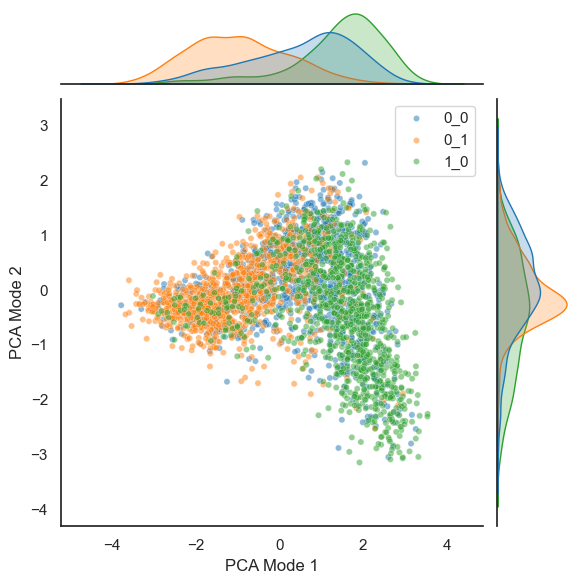

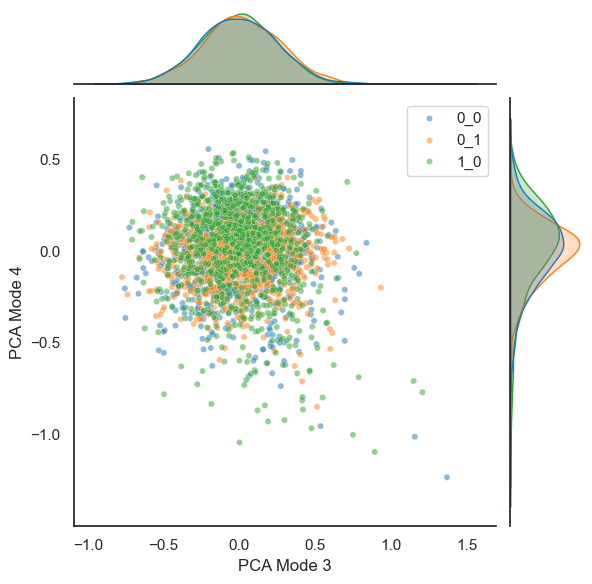

In [72]:
method = 'pca'
label = 'disease'

xdat = 'PCA Mode 1'
ydat = 'PCA Mode 2'

sns.set_theme(style="white", palette=None)

fig = sns.jointplot(
    x=xdat, y=ydat,
    hue=label,
    kind=kind,
    alpha=alpha,
    marker=style,
    s=markersize,
    data=sample_test,
    joint_kws=dict(rasterized=rasterized_scatter),
)
fig.ax_joint.legend(loc='upper right')
plt.savefig(method + '-' + model + '-disease-mode-1+2.' + out_format, bbox_inches='tight', dpi=300)
xlim = fig.ax_joint.get_xlim()
ylim = fig.ax_joint.get_ylim()


xdat = 'PCA Mode 3'
ydat = 'PCA Mode 4'

sns.set_theme(style="white", palette=None)
fig = sns.jointplot(
    x=xdat, y=ydat,
    hue=label,
    kind=kind,
    alpha=alpha,
    marker=style,
    s=markersize,
    # hue_order=['target_0', 'target_1'],
    data=sample_test,
    joint_kws=dict(rasterized=rasterized_scatter),
)
fig.ax_joint.legend(loc='upper right')
plt.savefig(method + '-' + model + '-disease-mode-1+2.' + out_format, bbox_inches='tight', dpi=300)
xlim = fig.ax_joint.get_xlim()
ylim = fig.ax_joint.get_ylim()

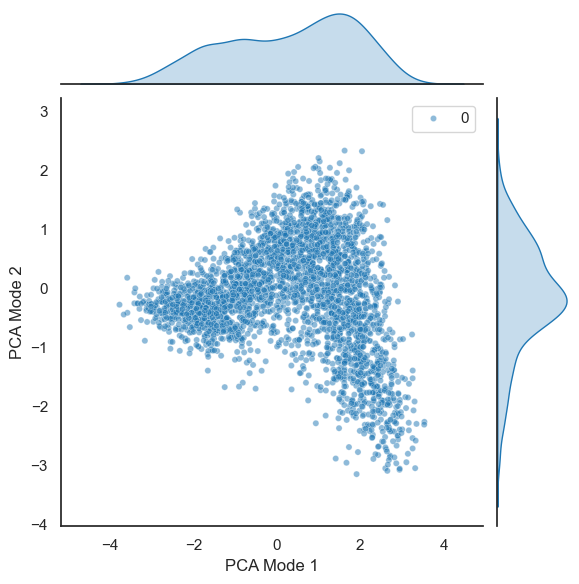

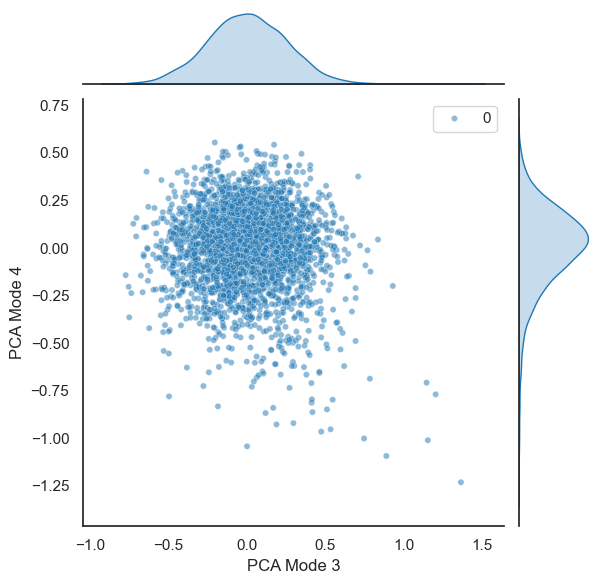

In [74]:
method = 'pca'
label = 'disease'

xdat = 'PCA Mode 1'
ydat = 'PCA Mode 2'

sns.set_theme(style="white", palette=None)

fig = sns.jointplot(
    x=xdat, y=ydat,
    hue=label,
    kind=kind,
    alpha=alpha,
    marker=style,
    s=markersize,
    data=sample_test,
    joint_kws=dict(rasterized=rasterized_scatter),
)
fig.ax_joint.legend(loc='upper right')
plt.savefig(method + '-' + model + '-disease-mode-1+2.' + out_format, bbox_inches='tight', dpi=300)
xlim = fig.ax_joint.get_xlim()
ylim = fig.ax_joint.get_ylim()


xdat = 'PCA Mode 3'
ydat = 'PCA Mode 4'

sns.set_theme(style="white", palette=None)
fig = sns.jointplot(
    x=xdat, y=ydat,
    hue=label,
    kind=kind,
    alpha=alpha,
    marker=style,
    s=markersize,
    # hue_order=['target_0', 'target_1'],
    data=sample_test,
    joint_kws=dict(rasterized=rasterized_scatter),
)
fig.ax_joint.legend(loc='upper right')
plt.savefig(method + '-' + model + '-disease-mode-1+2.' + out_format, bbox_inches='tight', dpi=300)
xlim = fig.ax_joint.get_xlim()
ylim = fig.ax_joint.get_ylim()